# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install torchinfo

In [3]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [4]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:02<00:00, 4206580.73it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28883093.42it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4859088.03it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


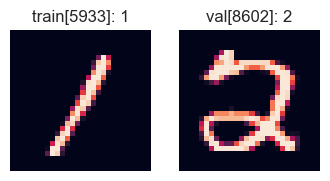

In [5]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [6]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [99]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))
    times =  []

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")
        times.append(time.time() - start_time)
        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history, times

In [145]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "darkred", 'lightblue']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

In [101]:
# Модель 0: предложенная в семинарском ноутбуке

model0 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.87
Input size (MB): 0.00
Forward/

In [102]:
# Модель 1: упрощенная модель

model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=10),
).to(device)

summary(model1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 10]                   54,090
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.22
Estimated Total Size (MB): 0.39

In [103]:
# Модель 2: без второго свёрточного слоя

model2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 256]                  1,384,704
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 1,387,594
Trainable params: 1,387,594
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.60
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.55
Estimated Total Size (MB): 5.73

In [104]:
# Модель 3: без второго линейного слоя

model3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=10)
).to(device)

summary(model3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 10]                   16,010
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38

In [105]:
# Модель 4: много свёрточных слоёв

model4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=10)
).to(device)

summary(model4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 256, 3, 3]            147,712
├─MaxPool2d: 1-8                         [1, 256, 1, 1]            --
├─ReLU: 1-9                              [1, 256, 1, 1]            --
├─Flatten: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 10]                   2,570
Total params: 169,098
Trainable params: 169,098
Non-trainable params: 0


Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [106]:
models = [model0, model1, model2, model3, model4]
models_loss = {}
models_times = {}

In [107]:
for i, model in enumerate(models):
  
  print('Model {}'.format(i))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  history_cnn, time_cnn = train(
      model,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=20,
  )
  # Сохраняем веса модели в файл, history в словарь
  models_loss[i] = history_cnn
  models_times[i] = time_cnn
  torch.save(model.state_dict(), "model{}.pth".format(i))
  print('----------------------')

Epoch 20 of 20 took 20.615 s
  training loss: 	0.004040
  validation loss: 	0.057149
  training accuracy: 			99.89 %
  validation accuracy: 			98.92 %
----------------------


In [108]:
models_loss.keys()

dict_keys([0, 1, 2, 3, 4])

Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

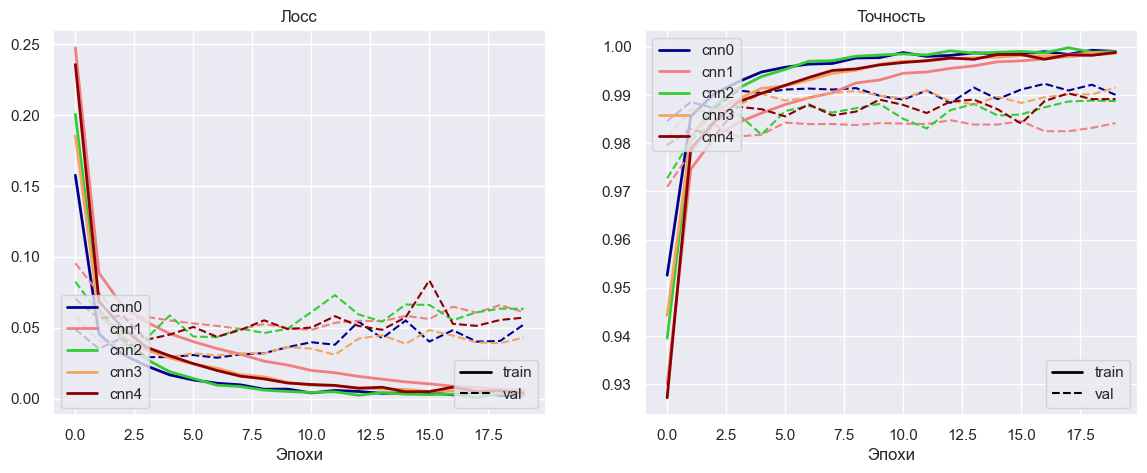

In [109]:
plot_histories([models_loss[0], models_loss[1], models_loss[2], models_loss[3], models_loss[4]], ['cnn0','cnn1', 'cnn2', 'cnn3', 'cnn4'])

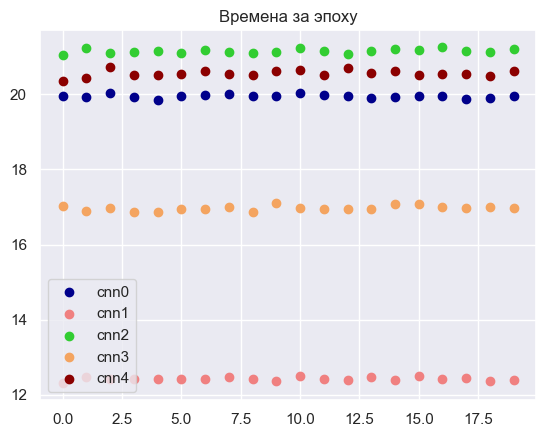

In [125]:
colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "darkred"]
for i in range(5):
    plt.scatter(range(20), models_times[i], label='cnn{}'.format(i), color=colors[i])
plt.title('Времена за эпоху')
plt.legend()
plt.show()

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** *Точность:* По графикам видно, что на начальных эпохах модель с наименьшим кол-вом свёрточных и линейных слоёв отстаёт, так же её обучение до примерно тех же результатов требует большего кол-ва эпох. Поведение остальных моделей схоже, но можно подметить, что вариант с двумя свёрточными и двумя линейными имеет ровное изменение лосса и точности. *Время:* По графику видно, что самая простая модель сильно быстрее других проходит эпоху, затем третья(без второго линейного слоя), а самые долгие 2 и 5. Причём у 2 всего один свёрточный солй, у 5 их 3, а у 0 - 2, в остольном они одинаковы. Из этого можно сделать вывод, что скорость обучения может меняться в зависимости от правильного подбора слоёв.

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Выбран вариант CNN0

In [14]:
model0_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.87
Input size (MB): 0.00
Forward/

In [15]:
model0_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 10, 10]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,754
Trainable params: 431,754
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.74
Input size (MB): 0.00
Forward/

In [16]:
model0_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 9, 9]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 316,554
Trainable params: 316,554
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.63
Input size (MB): 0.00
Forward/

In [17]:
model0_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 317,066
Trainable params: 317,066
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.03
Input size (MB): 0.00
Forward/

In [134]:
model0_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3136, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           64
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─ReLU: 1-3                              [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           2,112
├─MaxPool2d: 1-5                         [1, 64, 7, 7]             --
├─ReLU: 1-6                              [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 256]                  803,072
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 807,818
Trainable params: 807,818
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.27
Input size (MB): 0.00
Forward/ba

In [140]:
model0_6 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model0_6, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 21, 21]           2,080
├─MaxPool2d: 1-2                         [1, 32, 10, 10]           --
├─ReLU: 1-3                              [1, 32, 10, 10]           --
├─Conv2d: 1-4                            [1, 64, 3, 3]             131,136
├─MaxPool2d: 1-5                         [1, 64, 1, 1]             --
├─ReLU: 1-6                              [1, 64, 1, 1]             --
├─Flatten: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 256]                  16,640
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 152,426
Trainable params: 152,426
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.12
Input size (MB): 0.00
Forwar

In [155]:
models_ex2 = [model0_1, model0_2, model0_3, model0_4, model0_5, model0_6]
models_loss_ex2 = {}
models_time_ex2 = {}

In [158]:
for i, model in enumerate(models_ex2):
  print('Model {}'.format(i))
  start_time = time.time()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  history_cnn, times = train(
      model,
      criterion,
      optimizer,
      train_batch_gen,
      val_batch_gen,
      num_epochs=20,
  )
  # Сохраняем веса модели в файл, history в словарь
  models_loss_ex2[i] = history_cnn
  models_time_ex2[i] = times
  torch.save(model.state_dict(), "model{}.pth".format(i))
  print('----------------------')

Epoch 20 of 20 took 16.840 s
  training loss: 	0.004894
  validation loss: 	0.072270
  training accuracy: 			99.85 %
  validation accuracy: 			98.91 %
----------------------


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

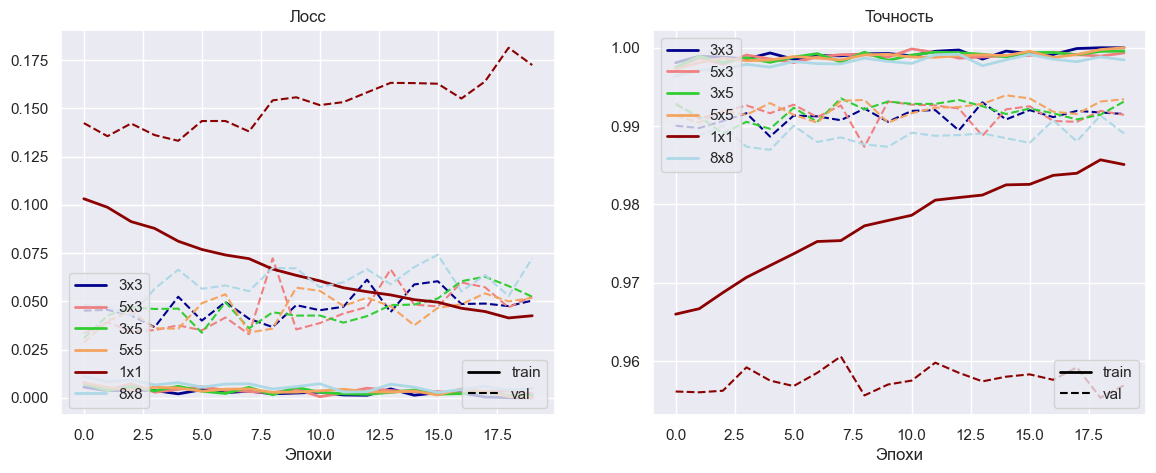

In [161]:
plot_histories([models_loss_ex2[0], models_loss_ex2[1], models_loss_ex2[2], models_loss_ex2[3], models_loss_ex2[4], models_loss_ex2[5]], ['3x3','5x3', '3x5', 
                                                                                                                      '5x5', '1x1', '8x8'])

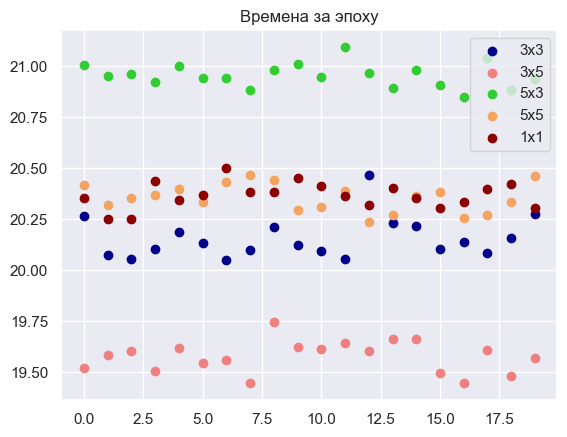

In [164]:
colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "darkred", 'lightblue']
kernels = ['3x3', '3x5', '5x3', '5x5', '1x1', '8x8']
for i in range(5):
    plt.scatter(range(20), models_time_ex2[i], label=kernels[i], color=colors[i])
plt.title('Времена за эпоху')
plt.legend()
plt.show()

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** <По графикам лосс и точность видно, что результат с хоть каким-то размером намного лучше чем без, но повышая размеры не факт, что повысится точность. Время также имеет зависимость, но трудно сказать какую именно.>

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

Выбрана модель model0_2 с ядром 5x3

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [79]:
# Цифра на картинке: [всего, угадоно, другое число определилось как  это]
num_acces = {0: [0, 0, 0], 1:[0, 0, 0], 2:[0, 0, 0], 3:[0, 0, 0], 4:[0, 0, 0], 5:[0, 0, 0], 6:[0, 0, 0], 7:[0, 0, 0], 8:[0, 0, 0], 9:[0, 0, 0]}
wrong_ids = []

for X_batch, y_batch in val_dataset:    
    num_acces[y_batch][0] += 1
    logits = model0_2(X_batch.to(device).unsqueeze(0))[0].cpu()
    y_pred = max(enumerate(logits),key=lambda x: x[1])[0]

    if y_pred != y_batch:
        wrong_ids.append((X_batch, y_batch))
        num_acces[y_batch][2] += 1
        continue

    num_acces[y_batch][1] += 1

In [93]:
for i in range(10):
    acc_per = num_acces[i][1]/(num_acces[i][0]) - num_acces[i][2]/(num_acces[i][0] + num_acces[i][2])
    print('Цифра: {}|\t Всего: {}|\t Угадано: {}|\t Спутано {}|\t Точность {:.3f}'.format(i, num_acces[i][0], num_acces[i][1], num_acces[i][2], acc_per))

Цифра: 0|	 Всего: 980|	 Угадано: 976|	 Спутано 4|	 Точность 0.992
Цифра: 1|	 Всего: 1135|	 Угадано: 1130|	 Спутано 5|	 Точность 0.991
Цифра: 2|	 Всего: 1032|	 Угадано: 1019|	 Спутано 13|	 Точность 0.975
Цифра: 3|	 Всего: 1010|	 Угадано: 1009|	 Спутано 1|	 Точность 0.998
Цифра: 4|	 Всего: 982|	 Угадано: 977|	 Спутано 5|	 Точность 0.990
Цифра: 5|	 Всего: 892|	 Угадано: 883|	 Спутано 9|	 Точность 0.980
Цифра: 6|	 Всего: 958|	 Угадано: 946|	 Спутано 12|	 Точность 0.975
Цифра: 7|	 Всего: 1028|	 Угадано: 1025|	 Спутано 3|	 Точность 0.994
Цифра: 8|	 Всего: 974|	 Угадано: 968|	 Спутано 6|	 Точность 0.988
Цифра: 9|	 Всего: 1009|	 Угадано: 993|	 Спутано 16|	 Точность 0.969


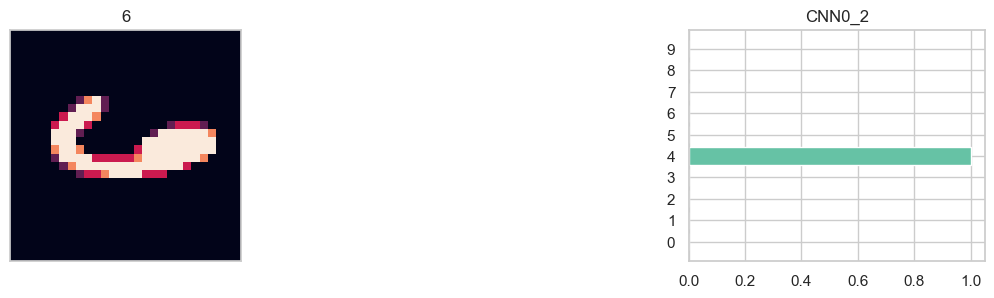

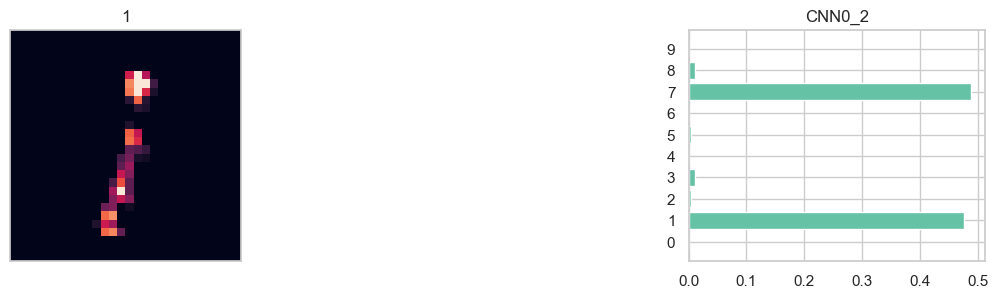

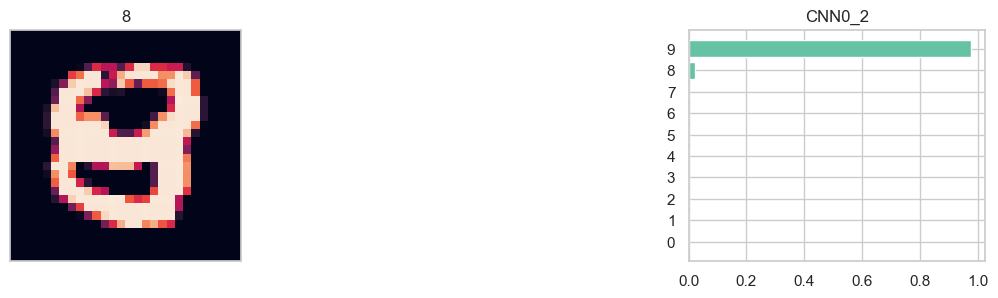

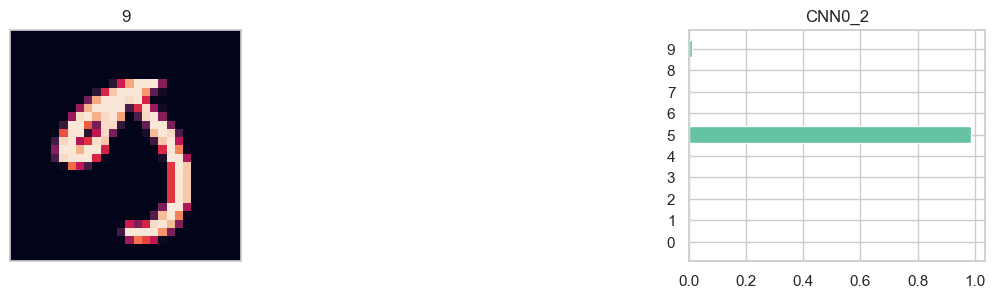

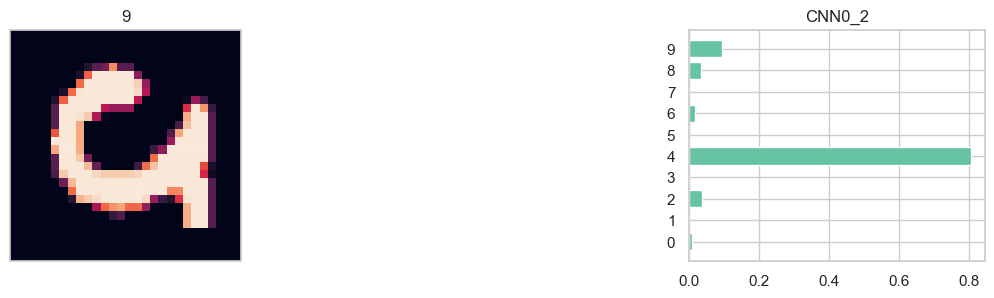

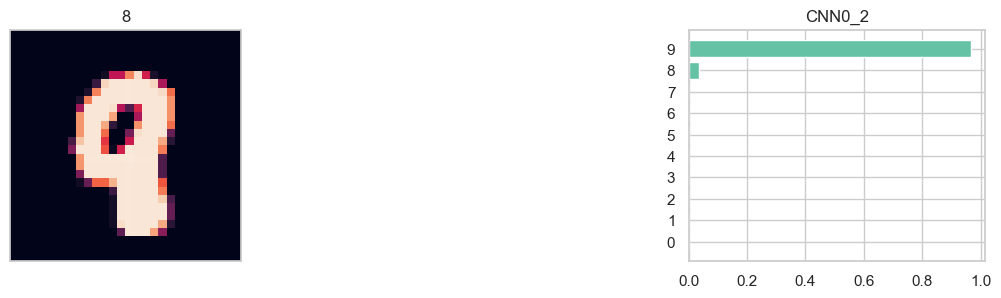

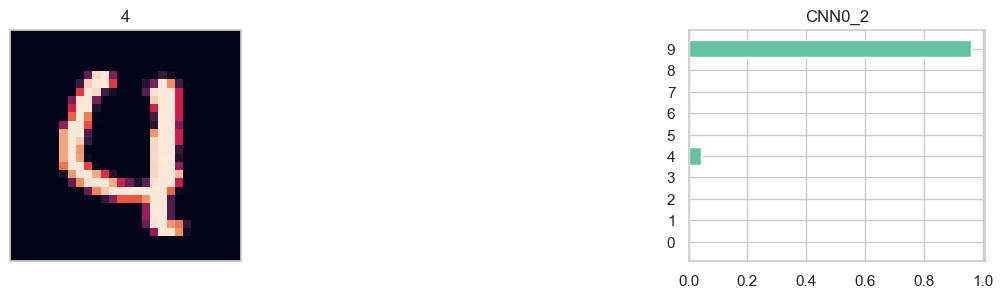

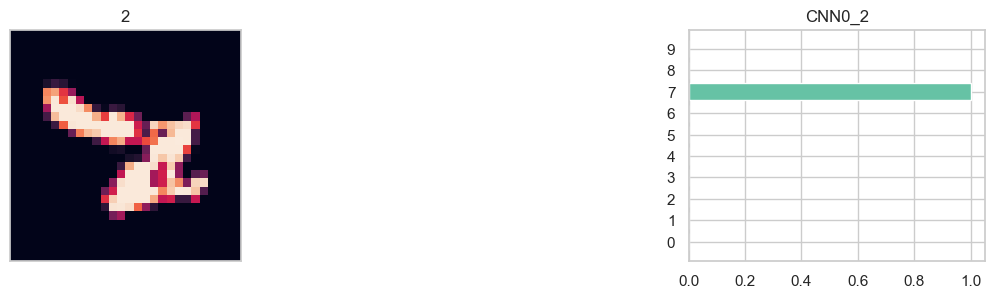

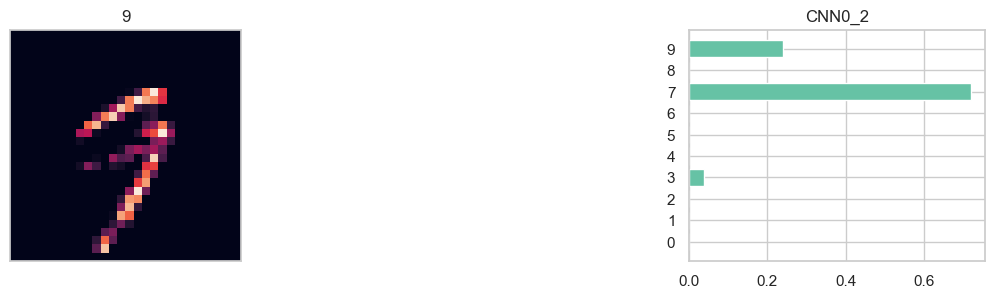

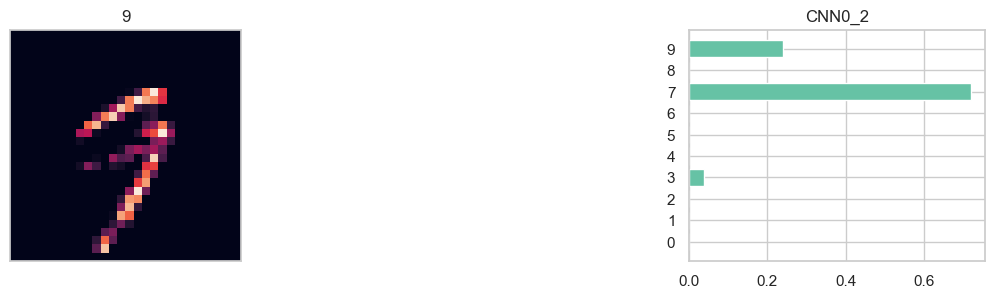

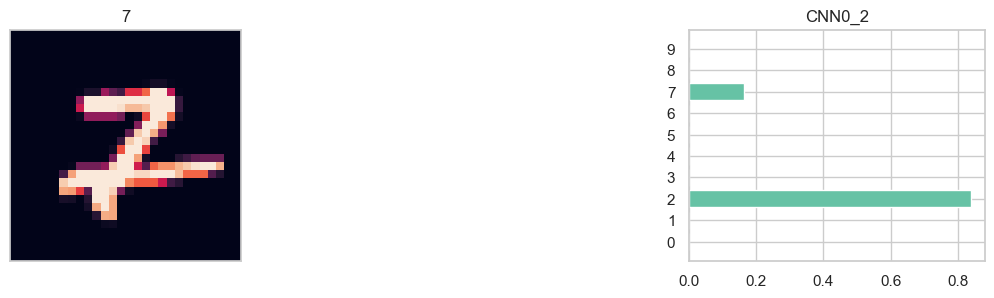

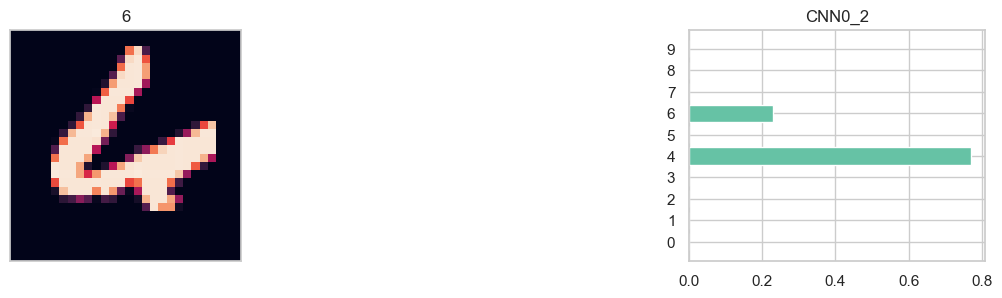

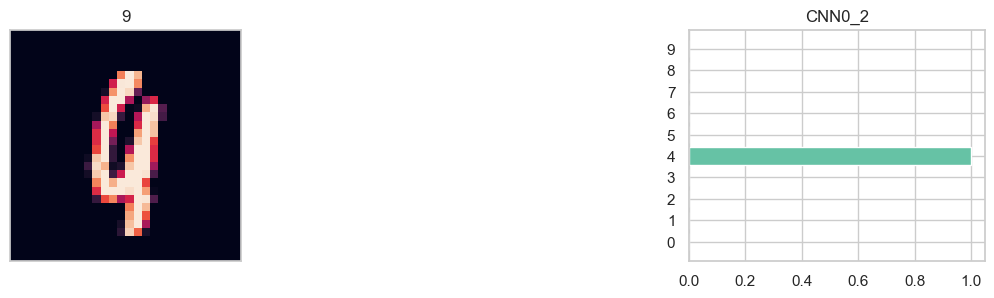

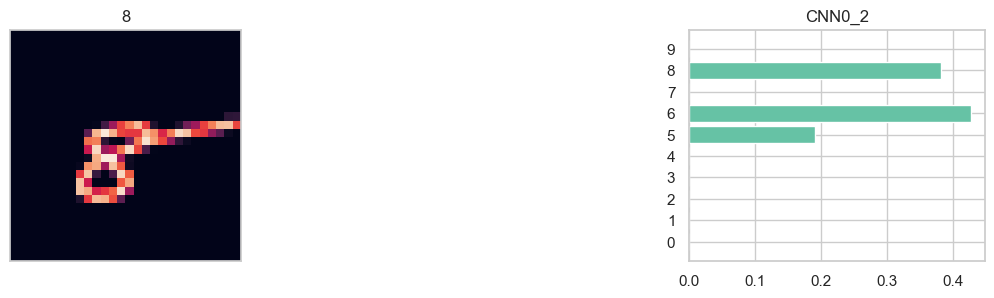

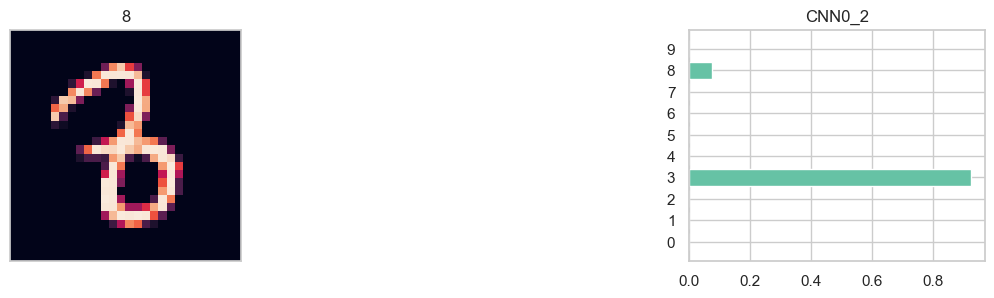

In [96]:
for i in np.random.randint(0, len(wrong_ids), 15):
    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(13, 3))

        # Достаем 1 рандомный объект из тестового датасета
        image, label = wrong_ids[i]

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute((1, 2, 0)))
        plt.title(label)
        plt.xticks([])
        plt.yticks([])

        # Не забываем выключить градиенты на момент вычислений
        with torch.no_grad():
            logits = model0_2(image.to(device).unsqueeze(0))[0].cpu()

        # Чтобы логиты перевести в вероятности применяем softmax по оси классов
        prob_cnn = torch.softmax(logits, dim=0)

        plt.subplot(1, 3, 3)
        plt.barh(classes, prob_cnn)
        plt.title("CNN0_2")

**Ответ:** <Точность определения "2", "5", "6" и "9" менее 98.1 процента, когда у остальных она около 99%. По примерам становится видно, что из-за схожих круглых(часто перекрывающихся) частей сеть путает эти числа. Так же из-за свёрточных слоёв возможно пропадает информация позволяющая отличить эти числа.>

**Вывод по всей задаче:** <С помощью CNN можно классифицировать объекты, причём даже простая модель на больших эпохах даёт неплохой результат. Но всё же меняя слои и ядра можно повышать эффективность. 100% навряд ли достигнет на валидационной выборке, так как в некоторых объектах присутствуют  признаки сразу нескольких.>

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [21]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


sns.set(palette="Set2")

In [20]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 1.4 MB/s eta 0:00:29
   ---------------------------------------- 0.2/38.6 MB 3.5 MB/s eta 0:00:12
   ---------------------------------------- 0.5/38.6 MB 4.7 MB/s eta 0:00:09
    --------------------------------------- 0.7/38.6 MB 5.7 MB/s eta 0:00:07
   - -------------------------------------- 1.1/38.6 MB 6.4 MB/s eta 0:00:06
   - -------------------------------------- 1.4/38.6 MB 7.3 MB/s eta 0:00:06
   - -------------------------------------- 1.4/38.6 MB 6.0 MB/s eta 0:00:07
   - -------------------------------------- 1.7/38.6 MB 6.7 MB/s eta 0:00:06
   -- ------------------------------------- 2.0/38.6 MB 6.3 MB/s eta 0:00:06
   -- ------------------------------------- 2.1/38.6 MB 6.1 MB/s eta 0:00:07
   -- ------------------------------------- 2.3/38.6 MB 6.0 MB/s eta 0:00:07
   -- ------------------------------------- 2.3/38.6 MB 6.0 MB/s eta 0:00:07
   -- 

In [26]:
%cd C:\Users\Ya Zdes Vlast\NNet\content\Neural-Style-Transfer

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

C:\Users\Ya Zdes Vlast\NNet\content\Neural-Style-Transfer


In [27]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [28]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [40]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=1200788471808.0000, content_loss=      0.0000, style loss=1200781920000.0000, tv loss=6522420.0000
L-BFGS | iteration: 100, total loss=11641673728.0000, content_loss=712268896.4844, style loss=10909432500.0000, tv loss=19972220.0000
L-BFGS | iteration: 200, total loss=1954481280.0000, content_loss=650764794.9219, style loss=1285877578.1250, tv loss=17838830.0000
L-BFGS | iteration: 300, total loss=1029324096.0000, content_loss=575289746.0938, style loss=437610615.2344, tv loss=16423752.0000
L-BFGS | iteration: 400, total loss=770542208.0000, content_loss=526516162.1094, style loss=228395712.8906, tv loss=15630349.0000
L-BFGS | iteration: 500, total loss=671463808.0000, content_loss=495142871.0938, style loss=161440415.0391, tv loss=14880540.0000
L-BFGS | iteration: 600, total loss=625625664.0000, content_loss=476519482.4219, style loss=134984838.8672, tv loss=14121372.0000
L-BFGS | iteration: 700, total loss

TypeError: 'NoneType' object is not subscriptable

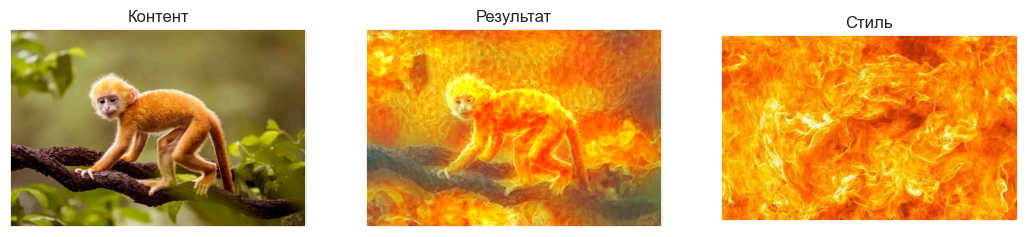

In [41]:
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Успел сделать только одну

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

Ни в колабе ни здесь не встала библиотека из-за ресурсов

**Вывод:**
<Подгоняя лоссы сразу двух вещей мы можем объединять их свойства. Но это требует больших ресурсов.>